## Imports

In [26]:
import optuna
from scipy.optimize import OptimizeResult
from helpers import *
from GD_LRS import *
from GD_SciPy import *
from GD_PIS import *
from GD_GSS import *
from NM_GSS import *

## Newton's method with line search using golden section search

In [27]:
def objective(trial):
    tol = trial.suggest_float("tol", 1e-8, 1e-4, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 2000)

    lr_init = trial.suggest_float("lr_init", 0.001, 1.0, log=True)
    decay_type = trial.suggest_categorical("decay_type", ["const", "step", "exp", "cosine"])

    if decay_type == "const":
        lr_schedule = lambda k: lr_init
    elif decay_type == "step":
        drop_rate = trial.suggest_float("drop_rate", 0.1, 0.9)
        step_size = trial.suggest_int("step_size", 5, 50)
        lr_schedule = lambda k: lr_init * (drop_rate ** (k // step_size))
    elif decay_type == "exp":
        decay_rate = trial.suggest_float("decay_rate", 0.001, 0.1)
        lr_schedule = lambda k: lr_init * np.exp(-decay_rate * k)
    else:  # cosine
        lr_max = trial.suggest_int("lr_max", 50, 500)
        eta_min = trial.suggest_float("eta_min", 0.0001, 0.1, log=True)
        lr_schedule = lambda k: eta_min + 0.5 * (lr_init - eta_min) * (1 + np.cos(k / lr_max * np.pi))

    test_cases = [
        (func_re, grad_re, [-3, -25], [-18, 16]),
        (rosenbrock, grad_rosenbrock, [-5, 3], [1, 1]),
        (himmelblau, grad_himmelblau, [-5, 3], None),
        (bukin, grad_bukin, [4, 4], [-10, 0]),
        (rastrigin, grad_rastrigin, [4, 4], [0, 0])
    ]

    try:
        total_error = 0
        total_iterations = 0

        for func, grad, init_point, optimal in test_cases:
            try:
                result = gd_lrs(func, grad, init_point, lr_schedule, tol=tol, max_iter=max_iter)

                if result.success is False:
                    # Если оптимизация не сошлась, возвращаем высокое значение ошибки
                    return float('inf')

                if optimal is not None:
                    error = np.linalg.norm(np.array(result.x) - np.array(optimal))
                else:
                    # Для Himmelblau находим ближайший минимум
                    min_error = float('inf')
                    for optimum in himmelblau_minima:
                        curr_error = np.linalg.norm(np.array(result.x) - np.array(optimum))
                        if curr_error < min_error:
                            min_error = curr_error
                    error = min_error

                total_error += error
                total_iterations += result.nit
            except Exception as e:
                # При возникновении ошибок возвращаем высокое значение
                #print(f"Ошибка при оптимизации: {e}")
                return float('inf')

        # Оптимизируем по комбинации ошибки и количества итераций
        score = total_error + 0.01 * total_iterations
        return score
    except Exception as e:
        print(f"Общая ошибка: {e}")
        return float('inf')


# Запуск оптимизации
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, catch=(Exception,))

# Вывод лучших параметров
if study.trials:
    print("Лучшие параметры:", study.best_params)
    print("Лучшее значение:", study.best_value)


[I 2025-04-13 22:44:55,898] A new study created in memory with name: no-name-b09463b3-10c1-480c-b459-56c8b829ffc3
[I 2025-04-13 22:44:55,902] Trial 0 finished with value: inf and parameters: {'tol': 5.774494814097943e-08, 'max_iter': 1954, 'lr_init': 0.16677140288961473, 'decay_type': 'cosine', 'lr_max': 81, 'eta_min': 0.012670047679505433}. Best is trial 0 with value: inf.
[I 2025-04-13 22:44:55,910] Trial 1 finished with value: inf and parameters: {'tol': 9.527943476308862e-05, 'max_iter': 1404, 'lr_init': 0.15399187331266012, 'decay_type': 'exp', 'decay_rate': 0.09435260858769948}. Best is trial 0 with value: inf.
[I 2025-04-13 22:44:55,920] Trial 2 finished with value: inf and parameters: {'tol': 6.755651054990567e-06, 'max_iter': 1890, 'lr_init': 0.005987409584271686, 'decay_type': 'cosine', 'lr_max': 287, 'eta_min': 0.009966604402035811}. Best is trial 0 with value: inf.
[I 2025-04-13 22:44:55,923] Trial 3 finished with value: inf and parameters: {'tol': 1.59126586111989e-08, 'ma

Лучшие параметры: {'tol': 5.774494814097943e-08, 'max_iter': 1954, 'lr_init': 0.16677140288961473, 'decay_type': 'cosine', 'lr_max': 81, 'eta_min': 0.012670047679505433}
Лучшее значение: inf


# 1. Rotated elliptical function

Method: Newton's Method
Initial point: [-3, -25]
Real minimum: [-18, 16]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-3.000, -25.000)       2825.000      1             52         43.657760 


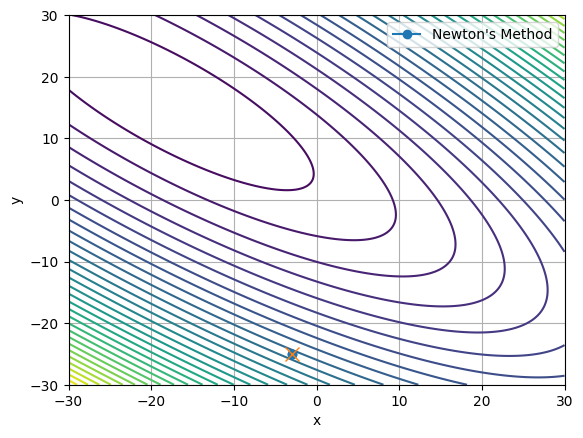

In [28]:
print_output([-3, -25], newton_method, func_re, grad_re, [-18, 16], label="Newton's Method", grid=[-30, 30])

# 2. Rosenbrock function

Method: Newton's Method
Initial point: [-5, 3]
Real minimum: [1, 1]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (1.000, 1.000)       0.000         18            869        0.000000  


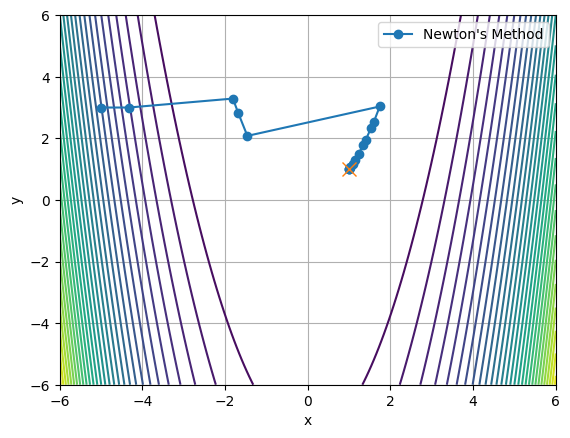

In [29]:
print_output([-5, 3], newton_method, rosenbrock, grad_rosenbrock, [1, 1], label="Newton's Method")


# 3. Himmelblau function

Method: Newton's Method
Initial point: [-5, 3]
Known minima: [[3, 2], [-2.805118, 3.131312], [-3.77931, -3.283186], [3.584428, -1.848126]]
Closest minimum: [-2.805118, 3.131312]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-2.805, 3.131)       0.000         37            1888       0.000001  


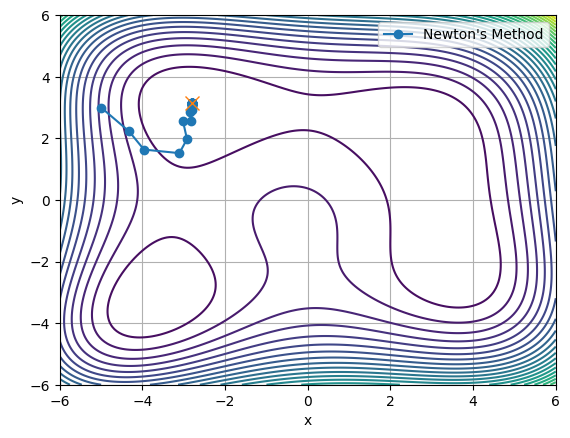

In [30]:
himmelblau_minima = [
    [3, 2],
    [-2.805118, 3.131312],
    [-3.779310, -3.283186],
    [3.584428, -1.848126]
]

print_output_multi_minima([-5, 3], newton_method, himmelblau, grad_himmelblau,
                          himmelblau_minima, label="Newton's Method")

# 4. Bukin function N 6

Method: Newton's Method
Initial point: [4, 4]
Real minimum: [-10, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.024, 0.091)       0.143         24            1225       13.023864 


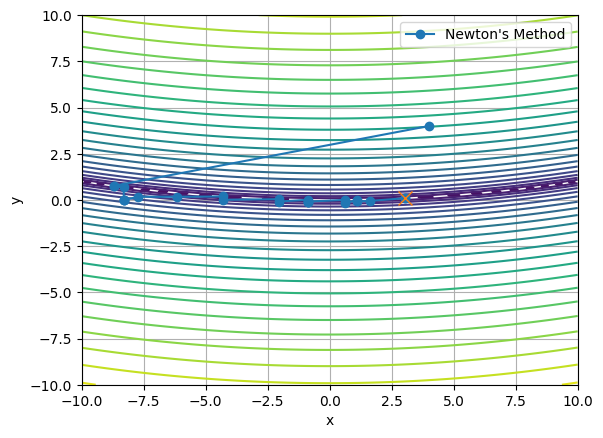

In [31]:
print_output([4, 4], newton_method, bukin, grad_bukin, [-10, 0], label="Newton's Method", grid=[-10, 10])


# 5. Rastrigin function


Method: Newton's Method
Initial point: [4, 4]
Real minimum: [0, 0]
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (1.897, -0.000)       3.801         9             460        1.896830  


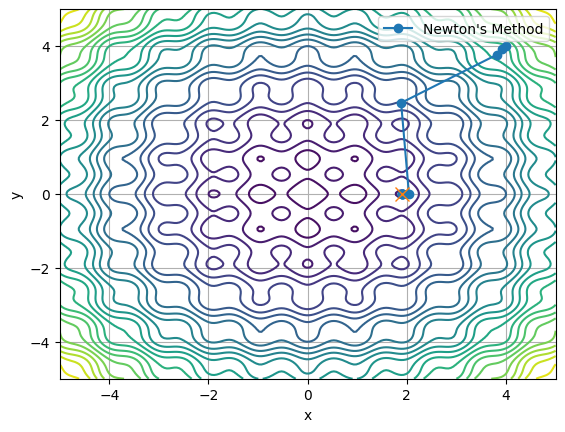

In [32]:
print_output([4, 4], newton_method, rastrigin, grad_rastrigin, [0, 0], label="Newton's Method", grid=[-5, 5])